In [ ]:
pip install alibi-detect

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_validate, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('train.csv', '../drive')
drive.descargar_archivos_concretos('test.csv', '../drive')

#hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

# Filtrar data_train
data_train = data_train[data_train['max_price'] < 100]

# Filtrar data_test
data_test = data_test[data_test['max_price'] < 100]

In [ ]:
data_train.describe()

,max_price,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,...,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold,min_price
count,409.000000,409.000000,4.090000e+02,409.000000,4.090000e+02,409.000000,409.000000,409.000000,409.000000,409.000000,...,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,40.999364,4.344743,2.761033e+06,57.817258,1.345203e+06,0.528117,2.051345,35.584352,0.141809,1.227384,...,0.004890,0.031785,0.078240,0.227384,0.572127,181.278729,1.848411,1.068460,1.518337,29.327726
std,22.410157,3.881957,2.441333e+06,11.117750,1.153698e+06,0.813379,1.541836,31.127951,0.349282,0.489731,...,0.069843,0.175642,0.268877,0.419656,0.495376,96.829067,15.594792,0.336079,1.111562,9.816920
min,10.000000,0.000000,1.940000e+02,0.000000,6.670000e+02,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-1.000000,1.000000,0.000000,9.000000
25%,23.000000,0.000000,2.760930e+05,56.000000,2.520000e+05,0.000000,1.000000,8.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,0.000000,1.000000,1.000000,22.000000
50%,35.000000,5.000000,3.903875e+06,60.904615,1.716398e+06,0.000000,1.000000,22.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,164.000000,0.000000,1.000000,1.000000,28.000000
75%,55.000000,8.000000,4.564084e+06,60.904615,1.716398e+06,1.000000,3.000000,65.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,231.000000,0.000000,1.000000,3.000000,35.000000
max,96.430000,10.000000,1.428030e+07,85.000000,1.120000e+07,3.000000,8.000000,85.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1036.000000,185.000000,5.000000,3.000000,72.000000


In [ ]:
data_test.describe()

,max_price,num_links,seguidoresSpotify,popularidad,subsYT,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,tiene_twitter,...,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,min_price,VenueClass
count,277.000000,277.000000,2.770000e+02,277.000000,2.770000e+02,277.000000,277.000000,277.000000,277.000000,277.000000,...,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,39.959819,2.906137,2.171663e+06,55.504593,2.384205e+06,1.400722,51.212996,0.068592,1.920578,0.386282,...,0.003610,0.021661,0.036101,0.231047,0.310469,192.487365,-0.028881,1.418773,31.340000,0.527076
std,22.778629,3.132092,8.715580e+05,5.645581,8.065752e+05,1.077638,53.046890,0.253217,3.049265,0.487778,...,0.060084,0.145836,0.186879,0.422265,0.463523,91.300531,0.502778,1.878002,14.936592,0.729917
min,10.500000,0.000000,7.320000e+03,18.000000,0.000000e+00,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,-1.000000,1.000000,10.500000,0.000000
25%,22.000000,0.000000,2.572597e+06,56.162602,2.591877e+06,1.000000,11.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,137.000000,0.000000,1.000000,20.000000,0.000000
50%,32.000000,2.000000,2.572597e+06,56.162602,2.591877e+06,1.000000,41.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,183.000000,0.000000,1.000000,28.000000,0.000000
75%,60.000000,6.000000,2.572597e+06,56.162602,2.591877e+06,1.000000,79.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,228.000000,0.000000,1.000000,35.710000,1.000000
max,98.210000,9.000000,4.573236e+06,78.000000,6.070000e+06,8.000000,194.000000,1.000000,14.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1036.000000,3.000000,14.000000,90.000000,2.000000


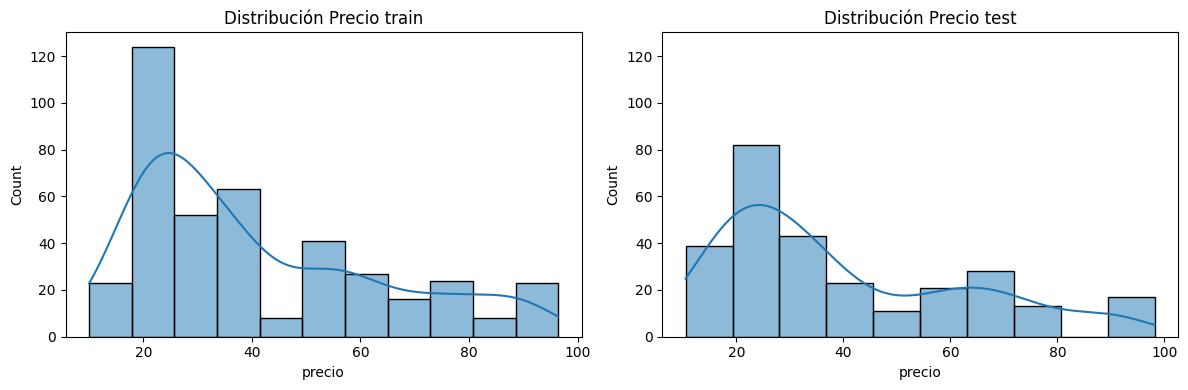

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='max_price', kde=True, ax=ax1)
ax1.set_title("Distribución Precio train")
ax1.set_xlabel('precio')

sns.histplot(data=data_test, x='max_price', kde=True, ax=ax2)
ax2.set_title("Distribución Precio test")
ax2.set_xlabel('precio')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

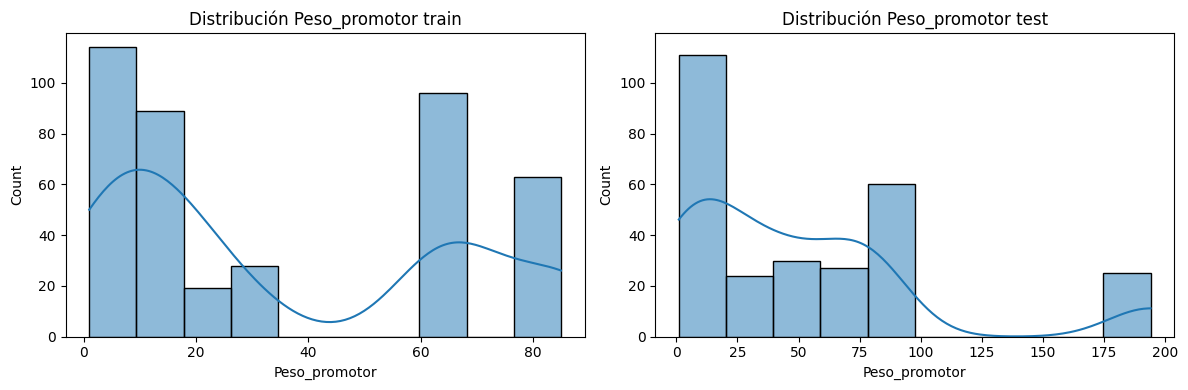

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='peso_promotor', kde=True, ax=ax1)
ax1.set_title("Distribución Peso_promotor train")
ax1.set_xlabel('Peso_promotor')

sns.histplot(data=data_test, x='peso_promotor', kde=True, ax=ax2)
ax2.set_title("Distribución Peso_promotor test")
ax2.set_xlabel('Peso_promotor')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

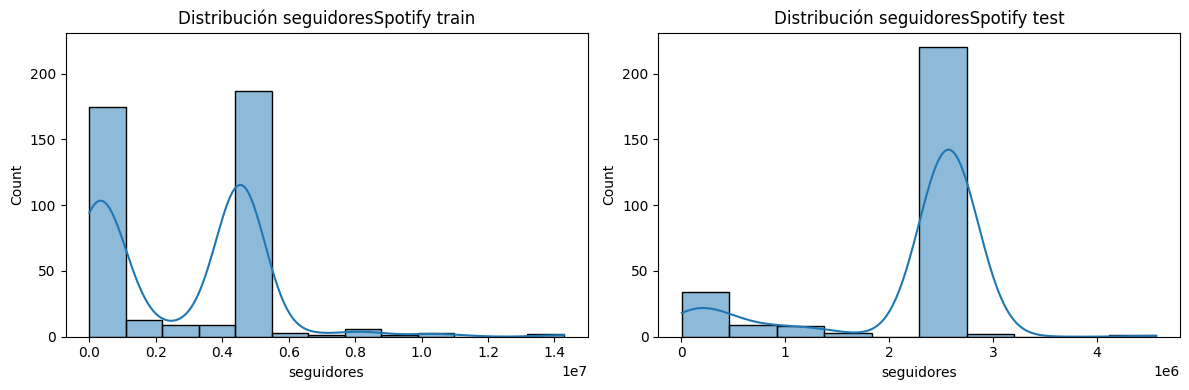

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='seguidoresSpotify', kde=True, ax=ax1)
ax1.set_title("Distribución seguidoresSpotify train")
ax1.set_xlabel('seguidores')

sns.histplot(data=data_test, x='seguidoresSpotify', kde=True, ax=ax2)
ax2.set_title("Distribución seguidoresSpotify test")
ax2.set_xlabel('seguidores')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

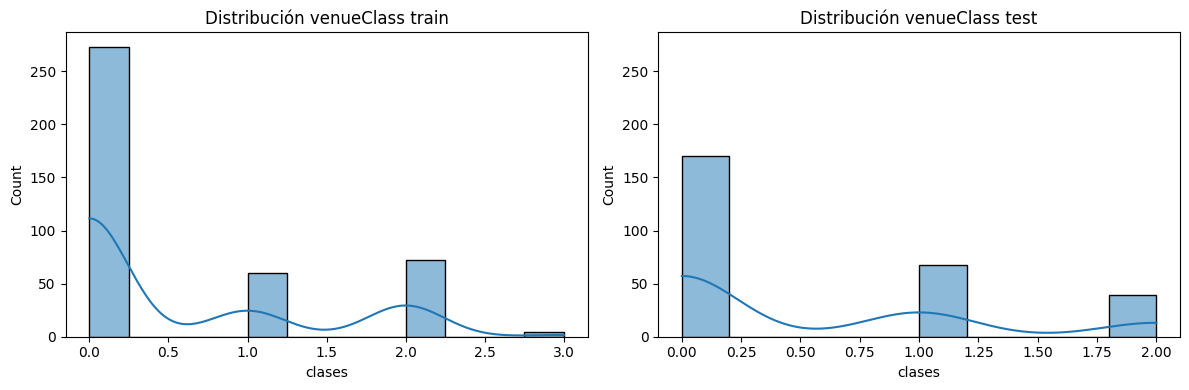

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=data_train, x='VenueClass', kde=True, ax=ax1)
ax1.set_title("Distribución venueClass train")
ax1.set_xlabel('clases')

sns.histplot(data=data_test, x='VenueClass', kde=True, ax=ax2)
ax2.set_title("Distribución venueClass test")
ax2.set_xlabel('clases')

# Encontrar el valor máximo de y en ambos gráficos
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Establecer el mismo límite para ambos ejes y
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

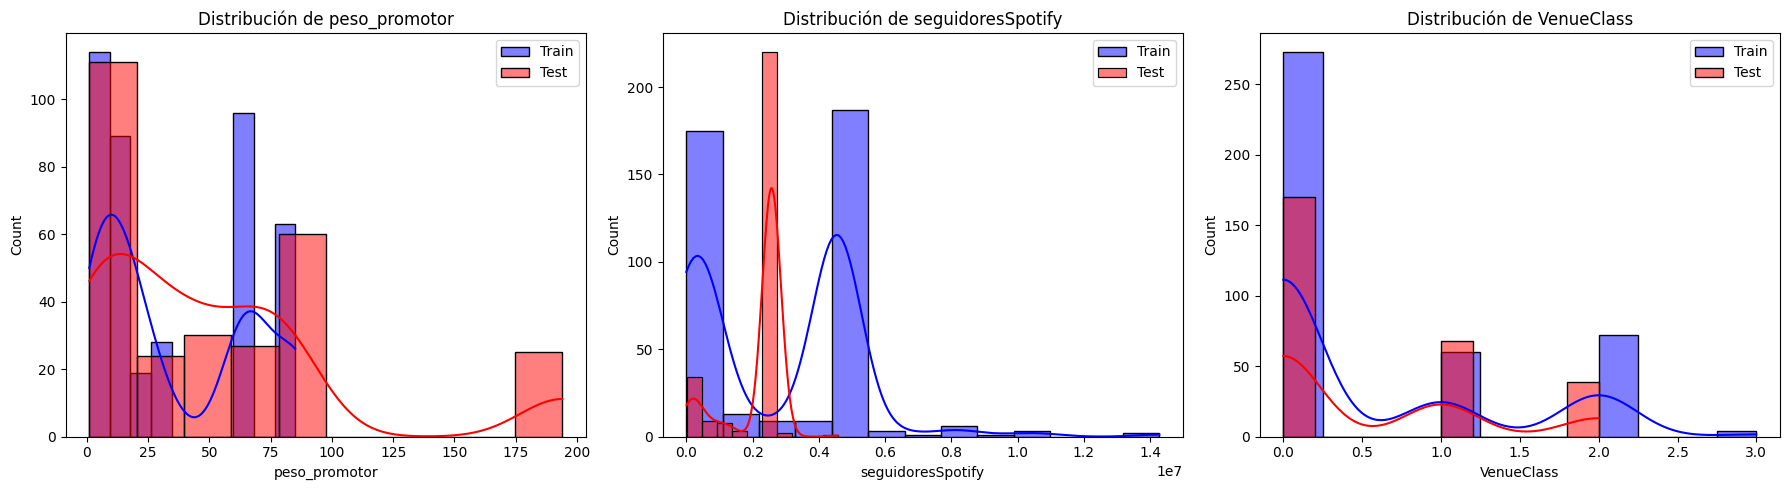

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables importantes
variables_importantes = ['peso_promotor', 'seguidoresSpotify', 'VenueClass']

# Crear figura con una única fila
plt.figure(figsize=(18, 5))

for i, var in enumerate(variables_importantes):
    plt.subplot(1, 3, i+1)  # 1 fila y 3 columnas
    sns.histplot(data_train[var], kde=True, color='blue', label='Train')
    sns.histplot(data_test[var], kde=True, color='red', label='Test')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.legend()

plt.tight_layout()
plt.show()


Podemos automatizar el proceso de detección de cambios en las distribuciones utilizando la librería Alibi Detector, que incorpora tests estadísticos como el de Kolmogorov-Smirnov (KS) que usaremos aquí.

Los resultados se interpretan como:
-	**Deriva Detectada**: Un valor True indica que se ha detectado una deriva significativa en los datos de la variable.
-	**P-value**: Un valor pequeño (menor que 0.05) indica que hay evidencia suficiente para rechazar la hipótesis nula de que las dos distribuciones son iguales.
-	**Estadística de la Prueba**: Proporciona una medida de la distancia entre las distribuciones de los datos de entrenamiento y prueba.


Comenzamos con seguidoresSpotify porque se ve que no se mantiene la distribución.

In [ ]:
import numpy as np
from alibi_detect.cd import KSDrift

# Preparar los datos
train_data_spotify = data_train['seguidoresSpotify'].values.reshape(-1, 1)
test_data_spotify = data_test['seguidoresSpotify'].values.reshape(-1, 1)

# Inicializar el detector de deriva
cd = KSDrift(train_data_spotify, p_val=0.05)

# Realizar la detección de deriva en el conjunto de prueba
preds = cd.predict(test_data_spotify)

# Resultados de la detección de deriva
print("Deriva detectada: ", preds['data']['is_drift'])
print("P-value: ", preds['data']['p_val'])
print("Estadística de la prueba: ", preds['data']['distance'])


Deriva detectada:  1
P-value:  [7.93e-43]
Estadística de la prueba:  [0.524622]


- **Deriva detectada: 1**. Sí, se ha detectado una deriva.

- **P-value: 7.93×10−43**. Este valor es extremadamente bajo, mucho menor que el umbral típico de 0.05, lo que indica que las distribuciones son significativamente diferentes.

- **Estadística de la prueba (D): 0.524622**. Este valor representa la mayor diferencia entre las distribuciones acumulativas de las dos muestras.

Y si lo hacemos ahora para todas las columnas que consideramos más importantes (las numéricas):

In [ ]:
import pandas as pd
from alibi_detect.cd import KSDrift

def check_data_drift(train_data, test_data, feature, p_val=0.05):
    train_data_feature = train_data[feature].dropna().values.reshape(-1, 1)
    test_data_feature = test_data[feature].dropna().values.reshape(-1, 1)

    cd = KSDrift(train_data_feature, p_val=p_val)
    preds = cd.predict(test_data_feature)

    is_drift = preds['data']['is_drift']
    p_value = preds['data']['p_val'][0]
    test_statistic = preds['data']['distance'][0]

    return is_drift, p_value, test_statistic

# columnas numéricas
no_binarias = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']

results = {}
for column in no_binarias:
    is_drift, p_value, test_statistic = check_data_drift(data_train, data_test, column)
    results[column] = {'is_drift': is_drift, 'p_value': p_value, 'test_statistic': test_statistic}

# Mostrar resultados
for column, result in results.items():
    if result['is_drift']:
        print(f"Deriva detectada en {column}!")
        print(f"P-value: {result['p_value']}")
        print(f"Estadística de la prueba: {result['test_statistic']}")
    else:
        print(f"No se detectó deriva en {column}.")


Deriva detectada en num_links!
P-value: 7.390958245423462e-08
Estadística de la prueba: 0.22555674612522125
Deriva detectada en seguidoresSpotify!
P-value: 7.931349308078465e-43
Estadística de la prueba: 0.5246220231056213
Deriva detectada en popularidad!
P-value: 0.0
Estadística de la prueba: 0.6434730887413025
Deriva detectada en subsYT!
P-value: 0.0
Estadística de la prueba: 0.8537420630455017
Deriva detectada en NumGeneros!
P-value: 5.4209818856065795e-09
Estadística de la prueba: 0.24201847612857819
Deriva detectada en peso_promotor!
P-value: 6.792569138269755e-07
Estadística de la prueba: 0.21052491664886475
No se detectó deriva en conciertos_del_artista_en_ciudad.
Deriva detectada en dias_Venta!
P-value: 0.006494812201708555
Estadística de la prueba: 0.13059942424297333
No se detectó deriva en dias_desdeFinVenta.
No se detectó deriva en num_noches.


Las únicas que no tienen cambios significativos en la distribución son:
conciertos_del_artista_en_ciudad, dias_desdeFinVenta y num_noches

In [ ]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados', 'min_price']

train = data_train.drop(columnas, axis=1)
train = train.drop('fold', axis=1)
test = data_test.drop(columnas, axis=1)

RANDOM_STATE = 83 #fijamos la semilla


In [ ]:
# Definir la variable objetivo y las características
y_train = train['max_price']
X_train = train.drop('max_price', axis=1)

# Definir la variable objetivo y las características
y_test = test['max_price']
X_test = test.drop('max_price', axis=1)

In [ ]:
X_test['New Wave']=0
X_test['Performance Art']=0

In [ ]:
X_test = X_test[X_train.columns]
X_test

,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,tiene_twitter,...,Rock,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches
1,7,2.817062e+06,75.000000,2.890000e+06,2,2,7,0,1.0,1,...,1,0,0,0,0,0,1,364,0,1
9,5,2.995447e+06,72.000000,2.410000e+06,1,3,1,0,1.0,1,...,1,0,0,0,0,0,1,229,0,1
11,0,2.572597e+06,56.162602,2.591877e+06,1,1,1,0,1.0,0,...,1,0,0,0,0,0,0,250,0,1
13,3,2.572597e+06,56.162602,2.591877e+06,1,1,17,0,1.0,0,...,1,0,0,0,1,1,0,99,0,1
14,0,2.572597e+06,56.162602,2.591877e+06,2,1,2,0,1.0,0,...,1,0,0,0,0,0,0,252,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,6,1.850920e+05,52.000000,4.380000e+05,2,4,4,0,1.0,1,...,0,0,0,0,0,0,1,215,-1,1
330,0,2.572597e+06,56.162602,2.591877e+06,2,1,2,0,1.0,0,...,0,0,0,0,0,0,0,216,-1,1
331,0,2.572597e+06,56.162602,2.591877e+06,2,1,4,0,1.0,0,...,0,0,0,0,0,0,0,187,0,1
332,0,2.572597e+06,56.162602,2.591877e+06,2,1,1,0,1.0,0,...,0,0,0,0,0,0,0,211,0,1


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Definir el modelo RandomForestRegressor con los hiperparámetros dados
modelo_rf = RandomForestRegressor(n_estimators=50,
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_depth=35,
                                  random_state=RANDOM_STATE)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)
# Predecir en el conjunto de entrenamiento
y_pred_train = modelo_rf.predict(X_train)

# Calcular métricas sobre el conjunto de entrenamiento
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Métricas sobre el conjunto de entrenamiento:")
print("MAPE Train:", mape_train)
print("RMSE Train:", rmse_train)
print("MAE Train:", mae_train)

# Predecir en el conjunto de prueba
y_pred_test = modelo_rf.predict(X_test)

# Calcular métricas sobre el conjunto de prueba
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\nMétricas sobre el conjunto de prueba:")
print("MAPE Test:", mape_test)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)


Métricas sobre el conjunto de entrenamiento:
MAPE Train: 0.1249121460276038
RMSE Train: 7.243318670060958
MAE Train: 4.74567718073152

Métricas sobre el conjunto de prueba:
MAPE Test: 0.5673241683719061
RMSE Test: 20.75530819647833
MAE Test: 17.16078999554597


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Definir el modelo RandomForestRegressor sin hiperparámetros adicionales
modelo_rf_base = RandomForestRegressor(random_state=RANDOM_STATE)

# Entrenar el modelo
modelo_rf_base.fit(X_train, y_train)

# Predecir en el conjunto de entrenamiento
y_pred_train = modelo_rf_base.predict(X_train)

# Calcular métricas sobre el conjunto de entrenamiento
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("Métricas sobre el conjunto de entrenamiento:")
print("MAPE Train:", mape_train)
print("RMSE Train:", rmse_train)
print("MAE Train:", mae_train)

# Predecir en el conjunto de prueba
y_pred_test = modelo_rf_base.predict(X_test)

# Calcular métricas sobre el conjunto de prueba
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\nMétricas sobre el conjunto de prueba:")
print("MAPE Test:", mape_test)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)


Métricas sobre el conjunto de entrenamiento:
MAPE Train: 0.08200817827184974
RMSE Train: 4.7390200967005605
MAE Train: 3.1125365118174417

Métricas sobre el conjunto de prueba:
MAPE Test: 0.6345150672901267
RMSE Test: 21.650725450745806
MAE Test: 18.317953739040743


In [ ]:
modelo_rf_base.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
predicciones = modelo_rf_base.predict(X_test)

# Crear DataFrame con los precios reales, predichos y el nombre del concierto
df_predicciones = pd.DataFrame({
    'Nombre del Concierto': data_test['name'],
    'Precio Real': y_test,
    'Precio Predicho': predicciones
})
# Crear scatter plot interactivo con Plotly
fig = px.scatter(df_predicciones, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                 title='Comparación de Precios Reales vs Precios Predichos (Random Forest)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df_predicciones['Precio Real'].min(), y0=df_predicciones['Precio Real'].min(),
              x1=df_predicciones['Precio Real'].max(), y1=df_predicciones['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el gráfico interactivo
fig.show()


In [ ]:
def rmse_with_respect_to_median(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    median_actuals = np.median(actuals)
    squared_errors = (predictions - median_actuals) ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def mape_with_respect_to_median(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    median_actuals = np.median(actuals)
    percentage_errors = np.abs(predictions - median_actuals) / median_actuals
    mape = np.mean(percentage_errors) * 100
    return mape

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error

# Definir el modelo base sin hiperparámetros
modelo_rf_base = RandomForestRegressor(random_state=RANDOM_STATE)

# Entrenar el modelo con los datos de entrenamiento
modelo_rf_base.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_train_pred = modelo_rf_base.predict(X_train)

# Calcular las métricas para el conjunto de entrenamiento
metrics_train = {
    'MedAE': median_absolute_error(y_train, y_train_pred),
    'MedAPE': mape_with_respect_to_median(y_train_pred, y_train),
    'MedRMSE': rmse_with_respect_to_median(y_train_pred, y_train),
    'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
}

# Realizar predicciones en el conjunto de prueba
y_test_pred = modelo_rf_base.predict(X_test)

# Calcular las métricas para el conjunto de prueba
metrics_test = {
    'MedAE': median_absolute_error(y_test, y_test_pred),
    'MedAPE': mape_with_respect_to_median(y_test_pred, y_test),
    'MedRMSE': rmse_with_respect_to_median(y_test_pred, y_test),
    'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
}

# Imprimir los resultados de las métricas para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
for metric_name, metric_value in metrics_train.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Imprimir los resultados de las métricas para el conjunto de prueba
print("\nMétricas para el conjunto de prueba:")
for metric_name, metric_value in metrics_test.items():
    print(f"{metric_name}: {metric_value:.4f}")


# Crear DataFrame con los precios reales, predichos, desviación y el nombre del concierto
df_predicciones = pd.DataFrame({
    'Nombre del Concierto': data_test['name'],
    'Precio Real': y_test,
    'Precio Predicho': predicciones,
    'Desviación Absoluta': np.abs(y_test - predicciones)
})

# Crear scatter plot interactivo con Plotly
fig = px.scatter(df_predicciones, x='Precio Real', y='Precio Predicho', color='Desviación Absoluta',
                 title='Comparación de Precios Reales vs Precios Predichos (Random Forest)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'},
                 hover_data=['Nombre del Concierto', 'Desviación Absoluta'])

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df_predicciones['Precio Real'].min(), y0=df_predicciones['Precio Real'].min(),
              x1=df_predicciones['Precio Real'].max(), y1=df_predicciones['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el gráfico interactivo
fig.show()


Métricas para el conjunto de entrenamiento:
MedAE: 1.6927
MedAPE: 45.6749
MedRMSE: 20.8024
MAPE: 0.0820
RMSE: 4.7390

Métricas para el conjunto de prueba:
MedAE: 17.4042
MedAPE: 42.9356
MedRMSE: 17.6545
MAPE: 0.6345
RMSE: 21.6507



Características más importantes del modelo:
peso_promotor: 0.14290944970133282
Latin: 0.11328891726234257
dias_Venta: 0.1117680103735648
VenueClass: 0.10680559609203061
subsYT: 0.10297975844053739
dias_desdeFinVenta: 0.08991932241343462
popularidad: 0.04443206859049214
conciertos_del_artista_en_ciudad: 0.044019988004633505
num_links: 0.033167109646809766
seguidoresSpotify: 0.03289174888179522


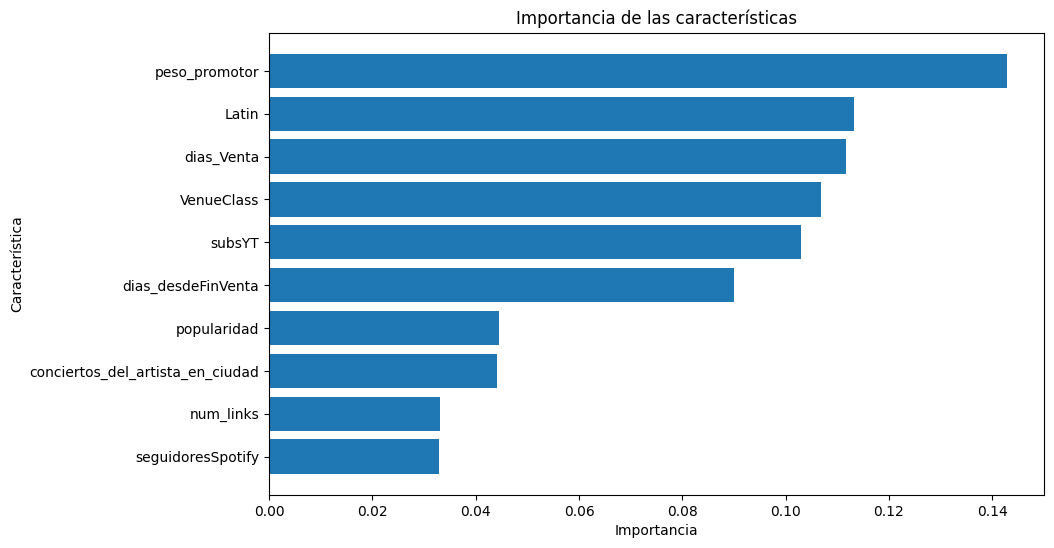

In [ ]:
# Importancia de las características
feature_importance_random = modelo_rf_base.feature_importances_
top_indices_random = np.argsort(feature_importance_random)[::-1][:10]

print("\nCaracterísticas más importantes del modelo:")
for i in top_indices_random:
    print(f"{X_test.columns[i]}: {feature_importance_random[i]}")

# Crear un DataFrame para las importancias de las características
df_feature_importance = pd.DataFrame({
    'Característica': X_test.columns[top_indices_random],
    'Importancia': feature_importance_random[top_indices_random]
})

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importance['Característica'], df_feature_importance['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.gca().invert_yaxis()
plt.show()

   VenueClass       rmse      mape
0           2  24.362690  0.601796
1           1  23.149818  0.405471
2           0  20.328854  0.733639


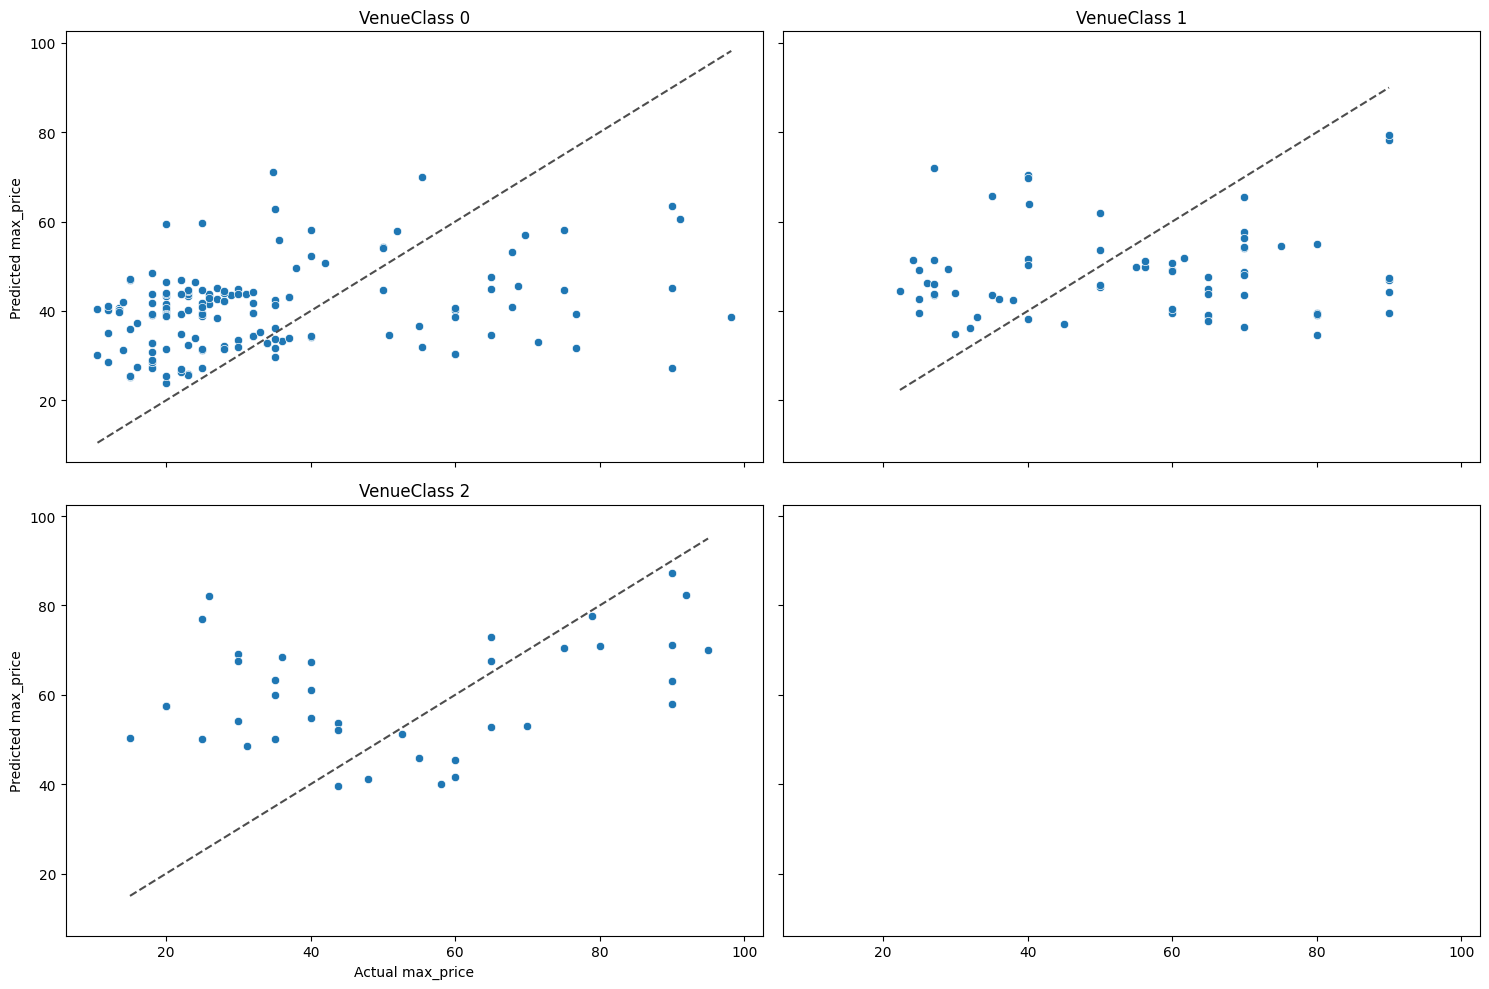

In [ ]:

# Copiar el DataFrame original
datos_segmentos = data_test.copy()
# Añadir las predicciones al DataFrame
datos_segmentos['pred'] = y_test_pred

# Lista para almacenar los resultados
resultados_list = []

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos_segmentos['VenueClass'].unique():
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    mse = mean_squared_error(subset['max_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['max_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)
print(resultados)

# Configurar la figura y los ejes
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Ordenar los datos
venue_classes = sorted(datos_segmentos['VenueClass'].unique())

# Generar gráficos de dispersión para cada "VenueClass"
for idx, vc in enumerate(venue_classes):
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['max_price'], y=subset['pred'])
    ax.plot([subset['max_price'].min(), subset['max_price'].max()],
            [subset['max_price'].min(), subset['max_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual max_price')
    ax.set_ylabel('Predicted max_price')

plt.tight_layout()
plt.show()


**HEURÍSTICA**

In [53]:
max_price_mean_by_venue_class_train = data_train.groupby('VenueClass')['max_price'].mean()
max_price_mean_by_venue_class_train

VenueClass
0    34.918828
1    47.206667
2    56.715278
3    80.000000
Name: max_price, dtype: float64

In [54]:
df_predicciones

,max_price_real,max_price_pred
1,90.0,71.161400
9,90.0,78.319300
11,90.0,79.301000
13,50.0,61.909767
14,92.0,82.415000
...,...,...
329,30.0,54.072200
330,40.0,67.320300
331,25.0,77.005700
332,95.0,69.967400


In [55]:

data_test['max_price_pred'] = y_test_pred  # Agregar las predicciones al DataFrame data_test


In [56]:
data_test['MaxPrice Real Medio'] = data_test['VenueClass'].map(max_price_mean_by_venue_class_train)


In [57]:
data_test['Diferencia Predicción vs Real Medio'] = data_test['max_price_pred'] - data_test['MaxPrice Real Medio']


In [58]:
media_diferencia_por_evento = data_test.groupby('VenueClass')['Diferencia Predicción vs Real Medio'].mean()

print("Media de la diferencia entre Predicción y Real Medio por Tipo de Evento:")
print(media_diferencia_por_evento)


Media de la diferencia entre Predicción y Real Medio por Tipo de Evento:
VenueClass
0    5.091495
1    1.344290
2    3.465473
Name: Diferencia Predicción vs Real Medio, dtype: float64


In [59]:
import plotly.express as px

# Crear una gráfica para cada tipo de venue_class (asegúrate de usar el nombre correcto de la columna)
fig = px.scatter(data_test, x='MaxPrice Real Medio', y='max_price_pred', color='VenueClass',
                 title='Comparación de Precios Predichos vs Precios Medios Reales por Tipo de Evento',
                 labels={'MaxPrice Real Medio': 'Precio Medio Real', 'max_price_pred': 'Precio Predicho'},
                 hover_data=['Diferencia Predicción vs Real Medio'])

# Agregar una línea diagonal que representa la igualdad entre los precios medios reales y los predichos
fig.add_shape(type='line',
              x0=data_test['MaxPrice Real Medio'].min(), y0=data_test['MaxPrice Real Medio'].min(),
              x1=data_test['MaxPrice Real Medio'].max(), y1=data_test['MaxPrice Real Medio'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el gráfico interactivo
fig.show()
